# Aortic Dissection Auto-segmentation for Computed Tomography (CT) 

This notebook is prepared for step-by-step description of auto-segmentation from the CT images of aortic dissection patients underwent TEVAR in Keck medical center.

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import json
import cv2
import imageio
import os, glob
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


import seaborn as sns
import umetrics

In [2]:
# Define Directories

# set home directory and data directory
HOME_DIR = "./volumes/test/"
DATA_DIR = HOME_DIR
P1_DIR   = "P1_CTA_Chest_08_17.nii"
P1_Mask  = "P1_Segmentation_08_17.nii"
P3_DIR   = "P3_CTA_Chest_08_18.nii"
P3_Mask  = "P3_Segmentation_08_18.nii"
P6_DIR   = "P6_CTA_Chest_08_19.nii"
P6_Mask  = "P6_Segmentation_08_19.nii"
def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

image, label = load_case(DATA_DIR + "img/"+P6_DIR, DATA_DIR + "mask/" + P6_Mask)

C:\Users\hengw\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

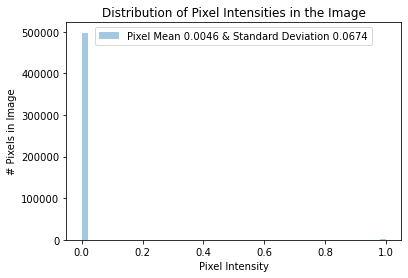

In [3]:
# Showing the Class Imbalance

# Plot a histogram of the distribution of the pixels
raw_image = label[50:150,50:150,50:100]

sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

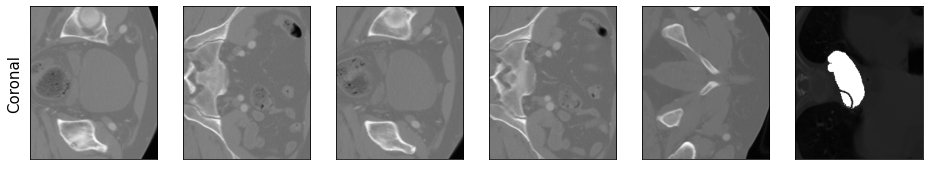

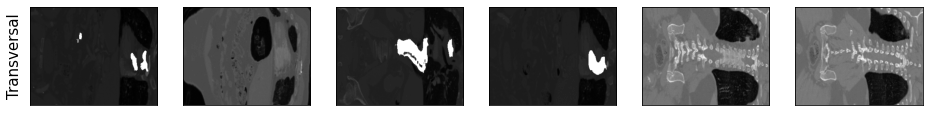

In [4]:
# Visualizing the Images

# Overlay the labels on top of the images

def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=2).astype(np.uint8)

    image = cv2.normalize(image[:, :, :], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

    labeled_image = np.zeros_like(label[:, :, :])
    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

data_all = get_labeled_image(image, label)
coronal, transversal = data_all, data_all

# coronal plane
fig, ax = plt.subplots(1, 6, figsize=[16,9])

for i in range(0, 6):
    n = np.random.randint(coronal.shape[2])
    ax[i].imshow(np.squeeze(coronal[:, :, n, 0]), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Coronal', fontsize=15)
# transversal plane
fig2, ax2 = plt.subplots(1, 6, figsize=[16,9])

for i in range(0, 6):
    n = np.random.randint(transversal.shape[1])
    ax2[i].imshow(np.squeeze(transversal[:, n, :, 0]), cmap='gray')
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    if i == 0:
        ax2[i].set_ylabel('Transversal', fontsize=15)

In [5]:
from ipywidgets import interact

faces = data_all[:, :, :, 0]
#faces_disp = 

print('Shape of the raw faces dataset: {}'.format(data_all.shape))
print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[2]))


@interact(n=(0, len(faces[0][0])-1))
def display_faces(n=0):
    #plt.figure()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(faces[:, :, n], cmap='gray')
    ax[1].imshow(label[:, :, n], cmap='gray')
    plt.show()

@interact(n=(0, len(faces[0])-1))
def display_faces(n=0):
    #plt.figure()
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(faces[:, n, :], cmap='gray')
    ax[1].imshow(label[:, n, :], cmap='gray')
    plt.show()

import imageio
images_scaled = [np.uint8(255 * image) for image in faces.T]
imageio.mimsave('movie.gif', images_scaled, format='gif', fps=60)

Shape of the raw faces dataset: (253, 211, 328, 2)
Shape of the faces dataset: (253, 211, 328)
328 data points


interactive(children=(IntSlider(value=0, description='n', max=327), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='n', max=210), Output()), _dom_classes=('widget-interact'…

In [6]:
#End of the Code